# Event Boundary to Polygon

This notebook shows how to generate polygons from nDI event. It will work even if the event has multiple pieces or has holes. 

Author: Jie Hou Modified Date: 11/27/2020

### Import necessary libraries

- GeoIO is used to read/write nDI data
- cv2 is used to generate the outline from the event

In [2]:
from geoio.geoio import GeoIoHorizonCollection, GeoIoEvent, GeoIoPolygonCollection, FileMode_update, GeoIoShapeSegment
import cv2
from matplotlib import pyplot as plt
import numpy as np

### Read event from a horizon collection

In [51]:
HORIZON_FILE = "/glb/data/siep_rii/sgsdata/usr/usjhs3/Data/Temp/2015_Ph3_CM1-2_MASP.int"

In [52]:
horizon_collection = GeoIoHorizonCollection(HORIZON_FILE)

In [53]:
event_names = horizon_collection.get_event_names()

In [54]:
event_names

('2015 Conger_CM1-2_Net_Sand_Isopach_MAD_Zoraster&17',
 'Conger_CM2_Net_Sand_Isopach_MAD&43703',
 'Conger_CM2_Net_Sand_Isopach_MAD_Zoraster&65546',
 'Conger_CM1_Net_Sand_Isopach_MAD_Zoraster&240290',
 'Top Conger CM sands_ph3_+90_zop_HandSmooContours_Zoraster&262133',
 'Conger_CM1_Net_Sand_Isopach_MAD&174761',
 'Base Conger CM sands_ph3_+90_zop_HandSmooContours_Zoraster&152918',
 '2015 Conger_CM1-2_Net_Pay_Isopach_MAD_Zoraster&131075',
 '2015 Conger_CM1-2_Net_Pay_Isopach_MAD_Zoraster_polygon_3&109232',
 'Conger_CM2_Net_Sand_Isopach_MAD_Polygon_3&87389',
 'Conger_CM2_Net_Sand_Isopach_MAD_Zoraster_polygon_3&21860',
 'Top Conger CM sands_ph3_+90_zop_HandSmooContours_Zoraster_polygon_3&218447',
 '2015 CM1 Top structure_HAFWL&196604')

### Get the x,y information about the horizon

In [55]:
survey = horizon_collection.get_survey()

In [56]:
coord_transform = survey.get_ijk_to_xyz_transform()

first_x, first_y, _ = coord_transform.to_target((0, 0, 0))
last_x, last_y, _ = coord_transform.to_target((survey.num_i()-1, survey.num_j()-1, 0))

delta_x = (last_x - first_x)/(survey.num_i()-1)
delta_y = (last_y - first_y)/(survey.num_j()-1)

x= np.linspace(first_x, last_x, survey.num_i())
y= np.linspace(first_y, last_y, survey.num_j())

extent= (first_x, last_x,first_y,last_y)


### Read the data from event and convert it to a binary image

In [57]:
event = horizon_collection.get_event(event_names[0])
data = event.get_picks()

In [58]:
data[~np.isnan(data)]=1

data = data.astype(np.uint8)

In [59]:
xgrid, ygrid = np.meshgrid(x,y)

/glb/data/siep_rii/sgsdata/usr/usjhs3/App/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


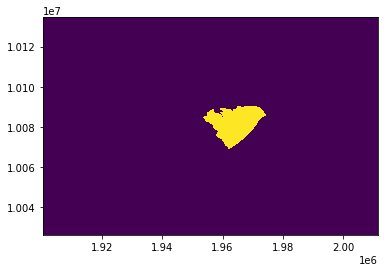

In [60]:
#plt.imshow(data, extent=extent, col = 'gray') #this is matplotlib solution (Figure 1)
plt.pcolormesh(xgrid,ygrid,data.T)
plt.show()

### Use OpenCV to generate the bounary from the binary image

In [61]:
ret,thresh1 = cv2.threshold(data,0,255,cv2.THRESH_BINARY) 

In [62]:
image,contours, _= cv2.findContours(data.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) #find contours

In [63]:
print('number of polygons: %d' % len(contours))


number of coins: 1


/glb/data/siep_rii/sgsdata/usr/usjhs3/App/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


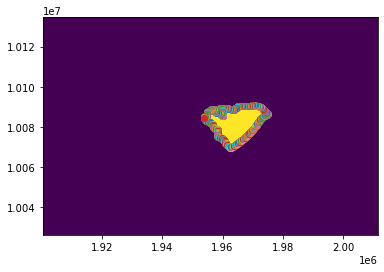

In [65]:
plt.figure()
plt.pcolormesh(xgrid,ygrid,data.T)
for i in range(len(contours)):
    x,y = contours[i][:,0,0],contours[i][:,0,1]
    coord = [coord_transform.to_target((y[i], x[i], 0)) for i in range(len(x))]    
    for j in range(len(x)):
        plt.scatter(coord[j][0],coord[j][1])

### Create a polygon collection and write the boundary as a polygon into the collection

In [66]:
outputpolygon = GeoIoPolygonCollection('output.ply',survey)

outputpoly = outputpolygon.create_polygon('Output_Polygon')

segments = list()
for i in range(len(contours)):
    x,y = contours[i][:,0,0],contours[i][:,0,1]
    coord = [coord_transform.to_target((y[i], x[i], 0)) for i in range(len(x))]
    coord.append(coord[0])
    outputpoly_points = list(coord)
    segment = GeoIoShapeSegment()
    segment.set_points(outputpoly_points)
    segments.append(segment)

outputpoly.set_segments(segments)

outputpolygon.delete_polygon(outputpoly.get_name())